$\large \text{REQUIREMENT 1: SINGLE PRODUCT AND STOCHASTIC ENVIRONMENT}$

$\text{PART 1: Build a pricing strategy using UCB1 ignoring the inventory constraint.}$

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

#Setting seed for reproducbility
np.random.seed(0) 

In [2]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer():
    def __init__(self, prices, cost):
    
        #Vector of possible prices of the product
        self.prices=prices

        #Probability to sell the product for each price
        #ASSUMPTION: valuation uniformly distribution  
        self.sell_probabilites = 1 - stats.uniform.cdf(self.prices, loc=0, scale=1)
        
        #Current round
        self.t = 0
        
        #Production cost
        self.production_cost=cost

    def round(self, p_t):

        # If the buyer buys the product we return 1 (0 othewise)
        s_t = int(np.random.rand() < self.sell_probabilites[p_t])

        #Utility: f_t=(selling price-production cost)*s_t
        price = self.prices[p_t]
        f_t = (price - self.production_cost) * s_t
        
        #Update of the current round
        self.t +=1
        
        return f_t

In [3]:
############################################################ CLASS SELLER ###################################################################################################################
        
class UCB1seller():
    
    def __init__(self, K, T, range=1):  
        
        #Number of prices
        self.K = K
        
        #Time horizon
        self.T = T
        
        #Scaling factor (set as 1)
        self.range = range
        
        #Chosen price 
        self.p_t = None
        
        #Average utilities
        self.average_utilities = np.zeros(K)
        
        #Number of pulls per price
        self.N_pulls = np.zeros(K)
        
        #Current round
        self.t = 0
    
    def pull_arm(self):
        
        #Exploration
        if self.t < self.K:
            self.p_t = self.t 
        else:
            #Compute the UCB of the utility for each price
            ucbs = self.average_utilities + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            
            #Compute the best arm
            self.p_t = np.argmax(ucbs)
            
        return self.p_t
    
    def update(self, f_t):
        
        #Update the number of pulls of the chosen arm
        self.N_pulls[self.p_t] += 1
        
        #Update the average utilities
        self.average_utilities[self.p_t] += (f_t - self.average_utilities[self.p_t])/self.N_pulls[self.p_t] 
        
        #Update the current round
        self.t += 1
        


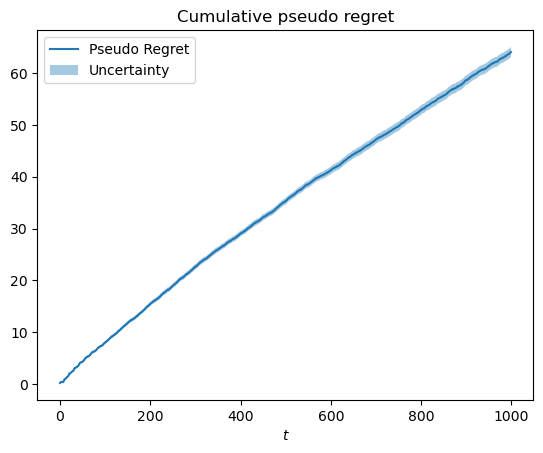

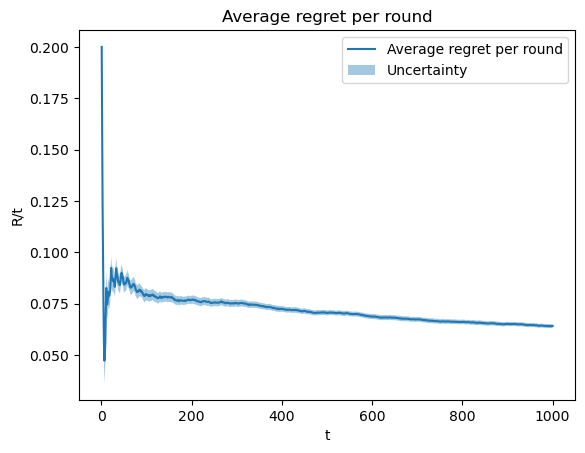

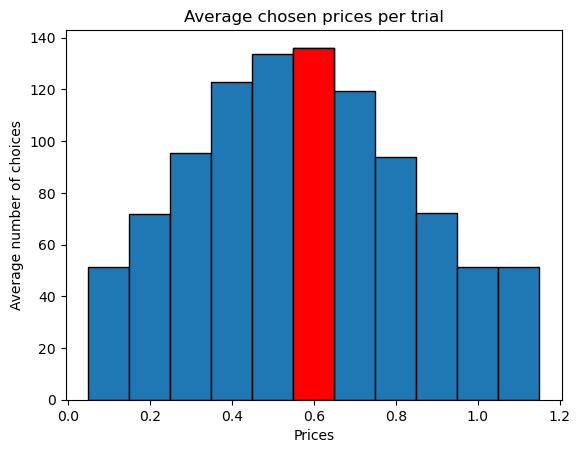

In [4]:
################################################### EXPERIMENT ###################################################################################################################

# Settings
T = 1000
prices = np.linspace(0.1, 1.1, 11) 
cost = 0.1
K = len(prices)
n_trials = 50

#CLAIRVOYANT

# Compute the selling probabilities
sell_probabilites = 1 - stats.uniform.cdf(prices, loc=0, scale=1)
# Compute the expected utilities
expected_utilities = (prices - cost) * sell_probabilites
best_utility = np.argmax(expected_utilities)
# Compute the expected clairvoyant utilities
expected_clairvoyant_utilities = np.repeat(expected_utilities[best_utility], T)

regret_per_trial = []

all_chosen_prices = []
all_success_prices = []

# Iterations
for x in range(n_trials):
    # Creazione di buyer e seller
    env = buyer(prices, cost)
    ucb_seller = UCB1seller(K, T)

    seller_utilities = np.array([])
    chosen_prices = []
    success_prices = []

    # Compute the seller utilities
    for t in range(T):
        p_t = ucb_seller.pull_arm()
        f_t = env.round(p_t)
        ucb_seller.update(f_t)

        seller_utilities = np.append(seller_utilities, f_t)
        chosen_prices.append(prices[p_t])   # Salvo il prezzo scelto
        if f_t > 0:                         # Solo se c’è stata una vendita
            success_prices.append(prices[p_t])

    # Cumulative regret
    cumulative_regret = np.cumsum(expected_clairvoyant_utilities - seller_utilities)
    regret_per_trial.append(cumulative_regret)


    all_chosen_prices.extend(chosen_prices)
    all_success_prices.extend(success_prices)


regret_per_trial = np.array(regret_per_trial)

# Mean and standard deviation of the regret 
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)




################################################### PLOTS ###################################################################################################################


# Plot 1: Cumulative pseudo regret vs time 
plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.title('Cumulative pseudo regret')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.4,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()


#Plot 2: Average Regret per round
times = np.arange(1, T+1)
plt.plot(times, (average_regret / times), label='Average regret per round')
plt.title('Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')

plt.xlabel('t')
plt.ylabel('R/t')
plt.legend()
plt.show()

# Plot 3: Average frequency of chosen prices per trial
counts, bins = np.histogram(all_chosen_prices, bins=len(prices))

avg_counts = counts / n_trials  
plt.bar(prices, avg_counts, width=(prices[1] - prices[0]), edgecolor='black')
plt.title("Average chosen prices per trial")
plt.xlabel("Prices")
plt.ylabel("Average number of choices")

if len(avg_counts) > 0:
    max_bin = np.argmax(avg_counts)
    plt.bar(prices[max_bin], avg_counts[max_bin],
            width=(prices[1] - prices[0]), color='red', edgecolor='black')
plt.show()




$\text{Part 2: Build a pricing strategy extending UCB1 to handle the inventory constraint}$

In [5]:
#Import libraries (same ones as above)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

In [6]:
############################################################ CLASS BUYER ####################################################################################################################

class buyer():
    def __init__(self, prices, cost):

        #Vector of possible prices of the product
        self.prices=prices

        #Probability to sell the product for each price
        #ASSUMPTION: valuation uniformly distribution 
        self.sell_probabilites = 1 - stats.uniform.cdf(self.prices, loc=0, scale=1)
        
        #Current round
        self.t = 0
        
        #Production cost
        self.production_cost=cost

    def round(self, p_t):
        
        if p_t==-1 :
           s_t=0
           f_t=0
        
        else:
            #If the buyer buys the product we return 1 (0 othewise)
            s_t = int(np.random.rand() < self.sell_probabilites[p_t])

            ##Utility: f_t=(selling price-production cost)*r_t
            price = self.prices[p_t]
            f_t = (price - self.production_cost) * s_t
            
        #Update the current round
        self.t +=1
        return s_t, f_t
    

In [7]:
############################################################ CLASS SELLER ###################################################################################################################

class UCBLikeSeller():
    
    def __init__(self, K, stock, T, range=1):
        
        #NUmber of prices
        self.K = K
        
        #Time horizon
        self.T = T
        
        #Scaling factor (set as 1)
        self.range = range
        
        #Chosen arm (integer number)
        self.p_t = None 
        
        #Average utility
        self.avg_f = np.zeros(K)
        
        #Average sold units per price
        self.avg_s = np.zeros(K)
        
        #Number of pulls per price
        self.N_pulls = np.zeros(K)
        
        #Inventory
        self.stock = stock
        
        #Budget per round
        self.rho = self.stock/T 
        
        #Current round
        self.t = 0

    
    def pull_arm(self):
        
        #In this case no selling 
        if self.stock < 1:  
            self.p_t = -1
            return self.p_t
        
        #Exploration
        if self.t < self.K:
            self.p_t = self.t 
            
        else:
            
            #Compute UCB of utility and LCB of sold items
            f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            s_lcbs = np.maximum(self.avg_s - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls),0)
            
            #Distribution from OPT
            gamma_t = self.compute_opt(f_ucbs, s_lcbs)
            
            #Sample the arm
            self.p_t = np.random.choice(self.K, p=gamma_t)
            
        return self.p_t

    
    def compute_opt(self, f_ucbs, s_lcbs):
        
        #OUTPUT: Find of gamma by solving a LP
        
        #Linear program
        f = -f_ucbs
        A_ub = [s_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        gamma = res.x
        
        return gamma
    
    def update(self, f_t, s_t):
        
        #Update number of pulls
        self.N_pulls[self.p_t] += 1   
           
        #Update average utility and sold units
        self.avg_f[self.p_t] += (f_t - self.avg_f[self.p_t])/self.N_pulls[self.p_t]
        self.avg_s[self.p_t] += (s_t - self.avg_s[self.p_t])/self.N_pulls[self.p_t]
        
        #Decrease stock
        self.stock -= s_t
        
        #Update round
        self.t += 1



In [8]:
############################################################ CLAIRVOYANT ###################################################################################################################

def compute_clairvoyant(available_prices, production_cost, rho, sell_probabilities):
    
    #OUTPUTS: the best probability distribution function "gamma" in expectation and the expected
    #utility per round choosing prices obtained using gamma

    #Multiply by sell_probabilities  because we want to make reasonings in expectation
    f = -(available_prices-production_cost)*sell_probabilities
    A_ub = [1*sell_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_prices))]
    b_eq = [1]
    
    #Solve LP
    res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    
    gamma = res.x
    

    return gamma, -(res.fun)

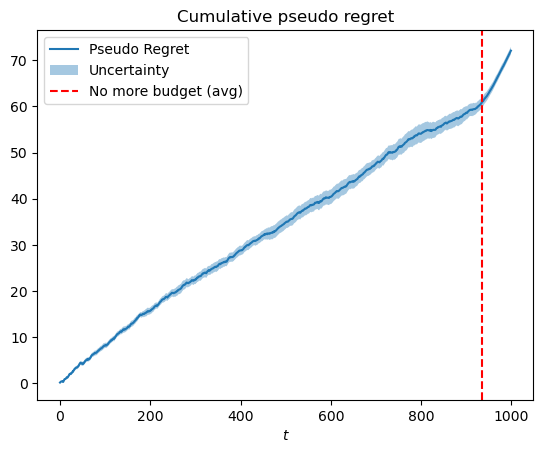

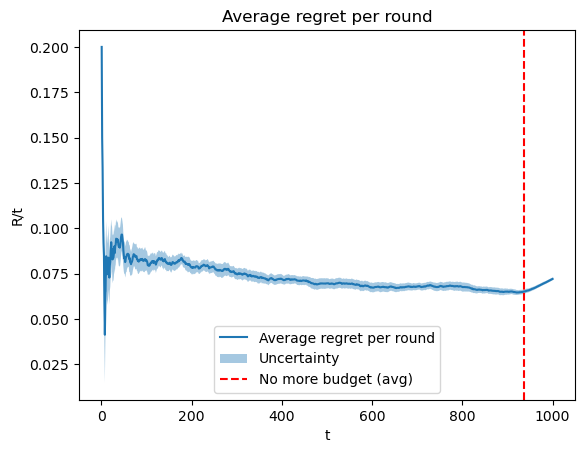

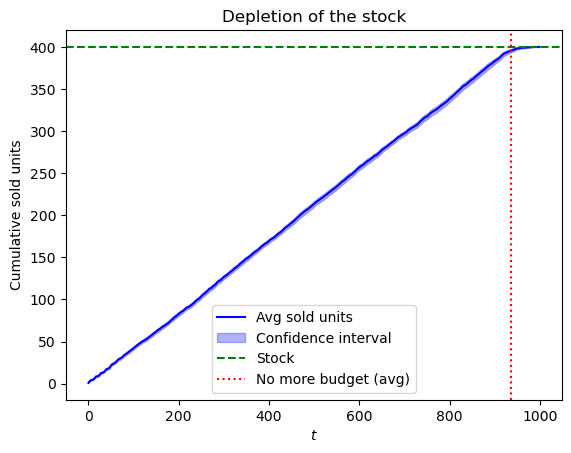

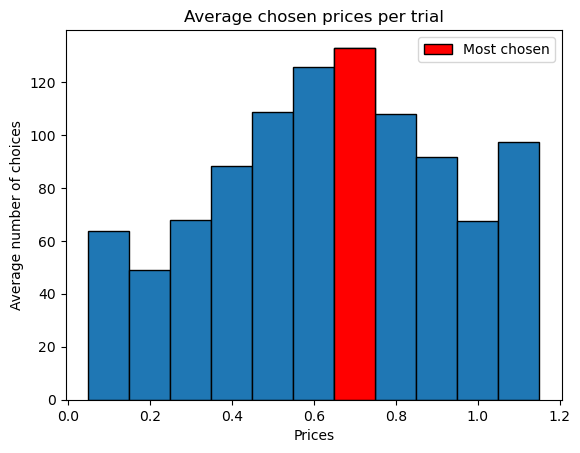

In [9]:
################################################### EXPERIMENT ###################################################################################################################

T = 1000
cost=0.1
prices = np.linspace(0.1, 1.1, 11)
K = len(prices)
stock = 400
rho = stock/T
n_trials = 10


# CLAIRVOYANT 
sell_probabilites = 1 - stats.uniform.cdf(prices, loc=0, scale=1)
gamma, expected_clairvoyant_utility = compute_clairvoyant(prices, cost, rho, sell_probabilites)
expected_clairvoyant_utilities = np.repeat(expected_clairvoyant_utility, T)

regret_per_trial = []
all_chosen_prices = []   
exhaustion_times=[]
sold_per_trial = []   # NEW: per salvare vendite cumulative di ogni trial


for n in range(n_trials): 
    ucb_seller = UCBLikeSeller(K=len(prices), stock=stock, T=T, range=1)
    env = buyer(prices, cost)
    
    seller_utilities = []
    products_sold = []
    chosen_prices = []
    count=0
    # Experiment
    for t in range(T):
        p_t = ucb_seller.pull_arm()
        
        if p_t==-1 and count==0: 
            exhaustion_times.append(t)
            count=1
            
        s_t, f_t = env.round(p_t)
        ucb_seller.update(f_t, s_t)

        seller_utilities = np.append(seller_utilities, f_t)
        products_sold = np.append(products_sold, s_t)
        chosen_prices.append(p_t) 

    # cumulative vendite trial
    cumulative_sold = np.cumsum(products_sold)
    if len(cumulative_sold) < T:
        cumulative_sold = np.append(cumulative_sold, np.zeros(T-len(cumulative_sold)))
    sold_per_trial.append(cumulative_sold)

    cumulative_regret = np.cumsum(expected_clairvoyant_utilities-seller_utilities)
    regret_per_trial.append(cumulative_regret)

    all_chosen_prices.extend(chosen_prices)   
    

regret_per_trial = np.array(regret_per_trial)
sold_per_trial = np.array(sold_per_trial)

# Mean and standard deviation of the regret 
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# Media vendite cumulative
avg_cumulative_sold = sold_per_trial.mean(axis=0)
sold_sd = sold_per_trial.std(axis=0)

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
else:
    avg_exhaustion_time = None



################################################### PLOTS ###################################################################################################################

# Plot 1: Cumulative pseudo regret vs time 
plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.title('Cumulative pseudo regret')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.4,
                label='Uncertainty')
plt.xlabel('$t$')

if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')

plt.legend()
plt.show()

#Plot 2: Average Regret per round
times = np.arange(1, T+1)
plt.plot(times, (average_regret / times), label='Average regret per round')
plt.title('Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')

plt.xlabel('t')
plt.ylabel('R/t')

if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()


# Plot 3: Number of units sold vs time (mean + IC)
plt.plot(np.arange(T), avg_cumulative_sold, label="Avg sold units", color="blue")

# Intervallo di confidenza
plt.fill_between(np.arange(T),
                 avg_cumulative_sold - sold_sd/np.sqrt(n_trials),
                 avg_cumulative_sold + sold_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.3, label="Confidence interval")

# Linea orizzontale stock
plt.axhline(y=stock, color='green', linestyle='--', label='Stock')

# Linea verticale esaurimento medio
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more budget (avg)')

plt.xlabel("$t$")
plt.ylabel("Cumulative sold units")
plt.title("Depletion of the stock")
plt.legend()
plt.show()


# Plot 4: Histogram - average frequency of chosen prices per trial
counts, bins = np.histogram(all_chosen_prices, bins=len(prices))
avg_counts = counts / n_trials   # media sul numero di trials

plt.bar(prices, avg_counts, width=(prices[1]-prices[0]), edgecolor='black')
plt.title("Average chosen prices per trial")
plt.xlabel("Prices")
plt.ylabel("Average number of choices")

max_bin = np.argmax(avg_counts)
plt.bar(prices[max_bin], avg_counts[max_bin],
        width=(prices[1]-prices[0]), color='red', edgecolor='black', label="Most chosen")
plt.legend()
plt.show()
